In [541]:
import numpy as np 
import pandas as pd 

import json
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import explained_variance_score, roc_auc_score, precision_recall_curve, roc_curve, average_precision_score,accuracy_score
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, cross_validate
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from mpl_toolkits.basemap import Basemap

import gc
import os
print(os.listdir("."))

['.DS_Store', 'Untitled.ipynb', 'test.csv', 'train-flattened.csv', 'test-flattened.csv', 'create-flattened-csv.ipynb', 'train.csv', '.ipynb_checkpoints', 'sample_submission.csv']


In [542]:
def load_df(csv_path, low_memory=False, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path, converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                         nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df



In [543]:

#train = load_df('./train.csv')
#test = load_df('./test.csv')


In [544]:

#train.info()


In [545]:

train_flat = pd.read_csv("train-flattened.csv", low_memory=False, nrows=None) #nrows=903653
test_flat = pd.read_csv("test-flattened.csv", low_memory=False, nrows=2000) #nrows=804684


In [546]:
train_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                                9036

In [547]:
#train.to_csv("train-flattened.csv", index=False)
#test.to_csv("test-flattened.csv", index=False)
#train_flat['channelGrouping'].unique()
#train_flat.head(100)

#print(train_flat['trafficSource.campaign'].unique())
#print(train_flat['trafficSource.campaignCode'].unique())
train_flat.head(10)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google
5,Organic Search,20160902,2938943183656635653,2938943183656635653_1472807194,Not Socially Engaged,1472807194,1,1472807194,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
6,Organic Search,20160902,1905672039242460897,1905672039242460897_1472817241,Not Socially Engaged,1472817241,1,1472817241,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
7,Organic Search,20160902,537222803633850821,537222803633850821_1472812602,Not Socially Engaged,1472812602,1,1472812602,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
8,Organic Search,20160902,4445454811831400414,4445454811831400414_1472805784,Not Socially Engaged,1472805784,1,1472805784,Internet Explorer,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
9,Organic Search,20160902,9499785259412240342,9499785259412240342_1472812272,Not Socially Engaged,1472812272,1,1472812272,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google


In [548]:
train_flat.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date,903653.0,2.016589e+07,4.697698e+03,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
visitId,903653.0,1.485007e+09,9.022124e+06,1.470035e+09,1.477561e+09,1.483949e+09,1.492759e+09,1.501657e+09
visitNumber,903653.0,2.264897e+00,9.283735e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.950000e+02
visitStartTime,903653.0,1.485007e+09,9.022124e+06,1.470035e+09,1.477561e+09,1.483949e+09,1.492759e+09,1.501657e+09
totals.bounces,450630.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
totals.hits,903653.0,4.596538e+00,9.641437e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+02
totals.newVisits,703060.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
totals.pageviews,903553.0,3.849764e+00,7.025274e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,4.690000e+02
totals.transactionRevenue,11515.0,1.337448e+08,4.482852e+08,1.000000e+04,2.493000e+07,4.945000e+07,1.076550e+08,2.312950e+10
totals.visits,903653.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [549]:

train_flat['totals.transactionRevenue'].fillna(0,inplace=True)

def fillNan(cols):
    for col in cols:
        train_flat[col].fillna(0,inplace=True)
        test_flat[col].fillna(0,inplace=True)
    
cols = ['trafficSource.adwordsClickInfo.page', 'trafficSource.isTrueDirect', 'totals.newVisits', 'totals.bounces', 'trafficSource.adwordsClickInfo.isVideoAd']
fillNan(cols);  

train_flat.describe()


,date,visitId,visitNumber,visitStartTime,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adwordsClickInfo.page
count,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05,903653.000000,903653.000000,903653.000000,903553.000000,9.036530e+05,903653.0,903653.000000
mean,2.016589e+07,1.485007e+09,2.264897,1.485007e+09,0.498676,4.596538,0.778020,3.849764,1.704273e+06,1.0,0.023941
std,4.697698e+03,9.022124e+06,9.283735,9.022124e+06,0.499999,9.641437,0.415578,7.025274,5.277866e+07,0.0,0.155811
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.0,0.000000
25%,2.016103e+07,1.477561e+09,1.000000,1.477561e+09,0.000000,1.000000,1.000000,1.000000,0.000000e+00,1.0,0.000000
50%,2.017011e+07,1.483949e+09,1.000000,1.483949e+09,0.000000,2.000000,1.000000,1.000000,0.000000e+00,1.0,0.000000
75%,2.017042e+07,1.492759e+09,1.000000,1.492759e+09,1.000000,4.000000,1.000000,4.000000,0.000000e+00,1.0,0.000000
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09,1.000000,500.000000,1.000000,469.000000,2.312950e+10,1.0,14.000000


In [550]:
train_flat['totals.transactionRevenueLog'] =  np.log1p(train_flat['totals.transactionRevenue'])

train_flat['totals.transactionRevenueLogNAN'] =  np.log1p(train_flat['totals.transactionRevenue'])
train_flat['totals.transactionRevenueLogNAN'].replace(0,np.nan,inplace=True)

In [551]:

train_flat.isna().sum()


channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
sessionId                                                 0
socialEngagementType                                      0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserSize                                        0
device.browserVersion                                     0
device.deviceCategory                                     0
device.flashVersion                                       0
device.isMobile                                           0
device.language                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceInfo                 

In [552]:

#cols_to_drop = []



#train_flat = train_flat.drop(columns=cols_to_drop)
train_flat.count()


channelGrouping                                      903653
date                                                 903653
fullVisitorId                                        903653
sessionId                                            903653
socialEngagementType                                 903653
visitId                                              903653
visitNumber                                          903653
visitStartTime                                       903653
device.browser                                       903653
device.browserSize                                   903653
device.browserVersion                                903653
device.deviceCategory                                903653
device.flashVersion                                  903653
device.isMobile                                      903653
device.language                                      903653
device.mobileDeviceBranding                          903653
device.mobileDeviceInfo                 

In [553]:
#populate count map from string values

continent_map = {}
continent_count = 0

country_map = {}
country_count = 0

city_map = {}
city_count = 0

def populate_maps(row):
    global continent_map
    global continent_count

    global country_map
    global country_count

    global city_map
    global city_count
    
    if row['geoNetwork.continent'] not in continent_map:
        continent_count+=1
        continent_map[row['geoNetwork.continent']] = continent_count
        
    if row['geoNetwork.country'] not in country_map:
        country_count+=1
        country_map[row['geoNetwork.country']] = country_count
        
    if row['geoNetwork.networkDomain'] not in city_map:
        city_count+=1
        city_map[row['geoNetwork.networkDomain']] = city_count
        
train_flat.apply (lambda row: populate_maps(row),axis=1)

print("done")

done


In [554]:
#drop columns containing more than 80% Nan values

cols_to_drop = ['trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 
               'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.slot', 
               'trafficSource.campaignCode', 'trafficSource.keyword', 'trafficSource.referralPath', 
               'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation',
               'device.screenResolution', 'device.screenColors', 'device.operatingSystemVersion',
               'device.mobileInputSelector', 'device.mobileDeviceModel', 'device.mobileDeviceMarketingName',
               'device.mobileDeviceInfo', 'device.mobileDeviceBranding','device.language', 'device.flashVersion',
               'device.browserVersion', 'device.browserSize', 'trafficSource.adwordsClickInfo.criteriaParameters', 
               'geoNetwork.cityId', 'socialEngagementType', 'sessionId', 'geoNetwork.city', 'geoNetwork.metro',
               'totals.visits']



train_flat = train_flat.drop(columns=cols_to_drop)

#drop rows where country is not set
train_flat = train_flat[train_flat['geoNetwork.country'] != '(not set)']



def string_to_int(train_flat):
    global continent_map
    global country_map
    global city_map
    
    train_flat['geoNetwork.networkDomain'] = train_flat['geoNetwork.networkDomain'].map(city_map)
    train_flat['geoNetwork.country'] = train_flat['geoNetwork.country'].map(country_map)
    train_flat['geoNetwork.continent'] = train_flat['geoNetwork.continent'].map(continent_map)

def clean_data(df):
    string_to_int(df)

string_to_int(train_flat)

train_flat.isna().sum()

channelGrouping                                  0
date                                             0
fullVisitorId                                    0
visitId                                          0
visitNumber                                      0
visitStartTime                                   0
device.browser                                   0
device.deviceCategory                            0
device.isMobile                                  0
device.operatingSystem                           0
geoNetwork.continent                             0
geoNetwork.country                               0
geoNetwork.networkDomain                         0
geoNetwork.region                                0
geoNetwork.subContinent                          0
totals.bounces                                   0
totals.hits                                      0
totals.newVisits                                 0
totals.pageviews                                98
totals.transactionRevenue      

In [555]:
train_flat.groupby('geoNetwork.continent')['fullVisitorId'].nunique()

geoNetwork.continent
1    196416
2     12901
3    167966
4    323208
5     13488
Name: fullVisitorId, dtype: int64

In [556]:

train_flat['datestr'] = pd.to_datetime(train_flat['date'].astype('str'), format='%Y%m%d')

train_flat['year'], train_flat['month'],train_flat['day'], train_flat['week']= train_flat['datestr'].apply(lambda x: x.year).astype('int64'), train_flat['datestr'].apply(lambda x: x.month).astype('int64'), train_flat['datestr'].apply(lambda x: x.day).astype('int64'), train_flat['datestr'].apply(lambda x: x.week).astype('int64')

train_flat['day_of_week'] = train_flat['datestr'].apply(lambda x: x.weekday())


In [557]:

train_flat['day'].unique()
train_flat['trafficSource.adwordsClickInfo.page'].unique()


array([  0.,   1.,   5.,   3.,   2.,  14.,   7.,   9.,   4.])

In [558]:
#find correlation with other columns
#train_flat.corr()['totals.transactionRevenueLog'].sort_values()
#train_flat.corr()['geoNetwork.city'].sort_values()

In [559]:
#train_flat.groupby('geoNetwork.networkDomain')['fullVisitorId'].nunique()

In [560]:

#np.count_nonzero(train_flat['totals.pageviews'])

#check if date is valid

#print(train_flat.groupby('geoNetwork.continent')['fullVisitorId'].nunique())
train_flat.corr()['totals.transactionRevenueLog'].sort_values()

#train_flat.groupby('device.browser')['fullVisitorId'].nunique()

totals.bounces                        -0.113074
totals.newVisits                      -0.107985
device.isMobile                       -0.046103
geoNetwork.networkDomain              -0.019665
day_of_week                           -0.014913
week                                  -0.002765
month                                 -0.002689
day                                   -0.000846
year                                   0.007635
date                                   0.007921
visitId                                0.010510
visitStartTime                         0.010510
trafficSource.adwordsClickInfo.page    0.010928
visitNumber                            0.023658
geoNetwork.country                     0.027716
geoNetwork.continent                   0.084946
totals.transactionRevenue              0.315505
totals.hits                            0.378821
totals.pageviews                       0.400744
totals.transactionRevenueLog           1.000000
totals.transactionRevenueLogNAN        1

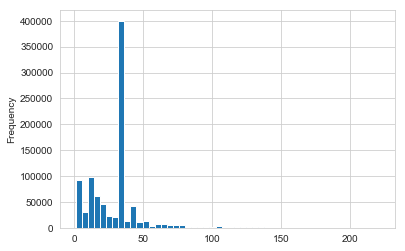

In [561]:
train_flat.shape
train_flat["geoNetwork.country"].plot.hist(bins=50)
plt.show()


/Users/rishabhjain/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/rishabhjain/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/rishabhjain/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


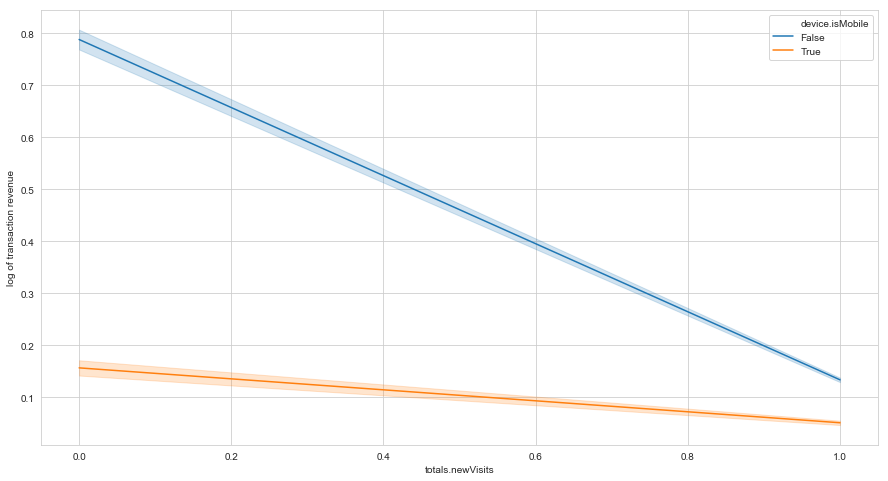

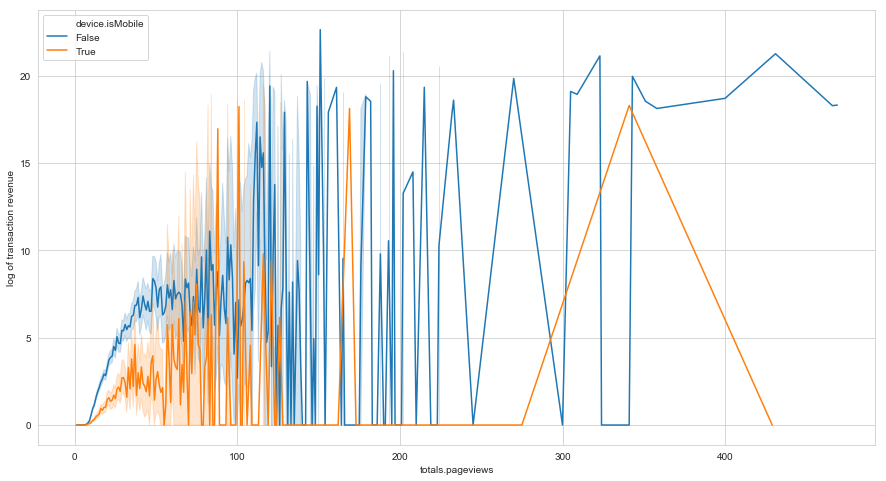

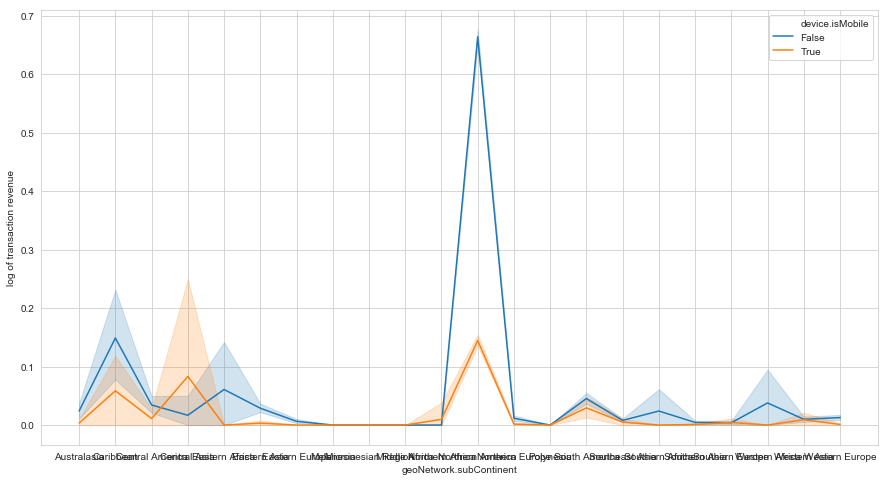

In [562]:


#print("Pearson correlation between time of day and distance travelled: %f" % 
#      stats.pearsonr(train_flat['totals.visits'], train_flat['totals.transactionRevenueLog'])[0])


def plot_lineplot(train_flat, cols, col_y):
    for col in cols:
        fig = plt.figure(figsize=(15,8))
        sns.set_style("whitegrid")
        g = sns.lineplot(col, col_y, hue='device.isMobile', data=train_flat)
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel('log of transaction revenue')# Set text for y axis
        fig.show()

col_y = train_flat['totals.transactionRevenueLog']
cat_cols = ['totals.newVisits', 'totals.pageviews', 'geoNetwork.subContinent']  
        
plot_lineplot(train_flat, cat_cols, col_y)

In [563]:
train_flat.info()

train_flat.replace([np.inf, -np.inf], np.nan)



train_flat = train_flat.dropna(subset=['totals.bounces', 'totals.newVisits', 'device.isMobile', 'geoNetwork.networkDomain', 
                 'trafficSource.adwordsClickInfo.page', 'visitStartTime', 'visitNumber', 'geoNetwork.continent',
                         'totals.hits', 'totals.pageviews', 'totals.transactionRevenueLog', 'totals.bounces',
                         'totals.newVisits', 'day_of_week', 'week', 'month', 'day', 'year', 'date',
                        'geoNetwork.country'], how='all')



<class 'pandas.core.frame.DataFrame'>
Int64Index: 902185 entries, 0 to 903652
Data columns (total 34 columns):
channelGrouping                             902185 non-null object
date                                        902185 non-null int64
fullVisitorId                               902185 non-null object
visitId                                     902185 non-null int64
visitNumber                                 902185 non-null int64
visitStartTime                              902185 non-null int64
device.browser                              902185 non-null object
device.deviceCategory                       902185 non-null object
device.isMobile                             902185 non-null bool
device.operatingSystem                      902185 non-null object
geoNetwork.continent                        902185 non-null int64
geoNetwork.country                          902185 non-null int64
geoNetwork.networkDomain                    902185 non-null int64
geoNetwork.region          

In [564]:


train_flat = train_flat[['totals.bounces', 'totals.newVisits', 'device.isMobile', 'geoNetwork.networkDomain', 
                 'trafficSource.adwordsClickInfo.page', 'visitStartTime', 'visitNumber', 'geoNetwork.continent',
                         'totals.hits', 'totals.pageviews', 'totals.transactionRevenueLog', 'day_of_week', 
                         'week', 'month', 'day', 'year', 'date', 'geoNetwork.country']]
train_flat = train_flat[np.isfinite(train_flat['totals.pageviews'])]


#train_flat = Imputer().fit_transform(train_flat)


In [566]:


def get_input_matrix(train_flat):
    return np.column_stack((train_flat['totals.bounces'], train_flat['totals.newVisits'], train_flat['device.isMobile'],
                            train_flat['geoNetwork.networkDomain'], train_flat['day_of_week'], train_flat['week'], 
                            train_flat['month'], train_flat['day'], train_flat['year'], train_flat['date'], 
                            train_flat['visitStartTime'], train_flat['trafficSource.adwordsClickInfo.page'], 
                            train_flat['visitNumber'], train_flat['geoNetwork.country'], train_flat['geoNetwork.continent'], 
                            train_flat['totals.hits'], train_flat['totals.pageviews']))

train_X = get_input_matrix(train_flat)
train_Y = train_flat['totals.transactionRevenueLog']

linear_reg_train_X, linear_reg_test_X , linear_reg_train_Y, linear_reg_test_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=23)

# Linear Regression model initialization (basic)
zillow_linear_regression = LinearRegression()

# Training the Linear Regression Model
zillow_linear_regression.fit(linear_reg_train_X, linear_reg_train_Y)

# Using the model to predict the test dataset
linear_reg_predicted_Y = zillow_linear_regression.predict(linear_reg_test_X)

# The coefficients of the linear equation aX1 + bX2 + cX3 + ... = Y
print('Coefficients (a,b,c,..) : ', [(x,y) for x,y in zip(train_X,zillow_linear_regression.coef_)])

# The mean squared error of the linear regression model's predictions
print("Mean squared error: %.5f" % mean_squared_error(linear_reg_test_Y, linear_reg_predicted_Y))

# Variance of the prediction
print('Variance : %.5f' % r2_score(linear_reg_test_Y, linear_reg_predicted_Y))


Coefficients (a,b,c,..) :  [(array([  1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   4.00000000e+00,   3.50000000e+01,
         9.00000000e+00,   2.00000000e+00,   2.01600000e+03,
         2.01609020e+07,   1.47283038e+09,   0.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00]), 0.32121312631189936), (array([  1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         2.00000000e+00,   4.00000000e+00,   3.50000000e+01,
         9.00000000e+00,   2.00000000e+00,   2.01600000e+03,
         2.01609020e+07,   1.47288015e+09,   0.00000000e+00,
         1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
         1.00000000e+00,   1.00000000e+00]), -0.29915965953798118), (array([  1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         3.00000000e+00,   4.00000000e+00,   3.50000000e+01,
         9.00000000e+00,   2.00000000e+00,   2.01600000e+03,
         2.01609020e+07,   1.47286539e+09

In [567]:
'''
from sklearn.svm import SVR

# Initializing the KNN object with the epsilon (error penalizing factor) to 0.05
# This value was experimented on using cross validation dataset and the analysis
# resulted in the model performing better for lower values
zillow_svm = SVR(C=1.0, epsilon=0.05)

# Spliting the dataset into train and test data
svm_train_X, svm_cross_valid_X , svm_train_Y, svm_cross_valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=12)

# Training the SVM
zillow_svm.fit(svm_train_X, svm_train_Y)

# Using the model to predict the test dataset
svm_predicted_Y = zillow_svm.predict(svm_cross_valid_X)

# The mean squared error of the SVM model's prediction
print("Mean squared error: %.5f" % mean_squared_error(svm_cross_valid_Y, svm_predicted_Y))

# Variance of the prediction
print('Variance : %.5f' % r2_score(svm_cross_valid_Y, svm_predicted_Y))
'''

'\nfrom sklearn.svm import SVR\n\n# Initializing the KNN object with the epsilon (error penalizing factor) to 0.05\n# This value was experimented on using cross validation dataset and the analysis\n# resulted in the model performing better for lower values\nzillow_svm = SVR(C=1.0, epsilon=0.05)\n\n# Spliting the dataset into train and test data\nsvm_train_X, svm_cross_valid_X , svm_train_Y, svm_cross_valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=12)\n\n# Training the SVM\nzillow_svm.fit(svm_train_X, svm_train_Y)\n\n# Using the model to predict the test dataset\nsvm_predicted_Y = zillow_svm.predict(svm_cross_valid_X)\n\n# The mean squared error of the SVM model\'s prediction\nprint("Mean squared error: %.5f" % mean_squared_error(svm_cross_valid_Y, svm_predicted_Y))\n\n# Variance of the prediction\nprint(\'Variance : %.5f\' % r2_score(svm_cross_valid_Y, svm_predicted_Y))\n'

In [569]:
#['totals.transactionRevenueLog' ]



cat_cols = []
num_cols = ['totals.bounces', 'totals.newVisits', 'device.isMobile',
                            'geoNetwork.networkDomain', 'day_of_week', 'week', 
                            'month', 'day', 'year', 'date', 
                           'visitStartTime', 'trafficSource.adwordsClickInfo.page',  
                            'visitNumber', 'geoNetwork.country', 'geoNetwork.continent', 
                            'totals.hits', 'totals.pageviews']
linear_reg_train_X, linear_reg_test_X , linear_reg_train_Y, linear_reg_test_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=23)

params = {"early_stopping_rounds":100, 
           "eval_metric" : 'rmse', 
            "eval_set" : [(linear_reg_train_X, linear_reg_train_Y)],
           'eval_names': ['valid'],
           'verbose': 100,
          'feature_name': num_cols,
         'categorical_feature': cat_cols 
         }



print('Start training...')
# train
gbm = lgb.LGBMRegressor(n_estimators=4000,                                         
                        learning_rate=0.017,            
                        num_leaves=68,            
                        metric= 'rmse',             
                        #max_bin=400,            
                        bagging_fraction=.8, #subsample            
                        feature_fraction=.8, #colsample_bytree            
                        bagging_frequency=10,            
                        bagging_seed=2018,            
                        max_depth=14,            
                        #reg_alpha=.2,            
                        #reg_lambda=.5,            
                        min_split_gain=.1,            
                        min_child_weight=.5,            
                        min_child_samples=300,            
                        silent=-1)
bst = gbm.fit(linear_reg_train_X, linear_reg_train_Y, **params)
print('done')

Start training...


/Users/rishabhjain/anaconda3/envs/python36/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/rishabhjain/anaconda3/envs/python36/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds.
[100]	valid's rmse: 1.66797
[200]	valid's rmse: 1.62157
[300]	valid's rmse: 1.60517
[400]	valid's rmse: 1.59887
[500]	valid's rmse: 1.59501
[600]	valid's rmse: 1.59163
[700]	valid's rmse: 1.58906
[800]	valid's rmse: 1.58632
[900]	valid's rmse: 1.58289
[1000]	valid's rmse: 1.58112
[1100]	valid's rmse: 1.57886
[1200]	valid's rmse: 1.57632
[1300]	valid's rmse: 1.57436
[1400]	valid's rmse: 1.57232
[1500]	valid's rmse: 1.57101
[1600]	valid's rmse: 1.56923
[1700]	valid's rmse: 1.56794
[1800]	valid's rmse: 1.5667
[1900]	valid's rmse: 1.56526
[2000]	valid's rmse: 1.56367
[2100]	valid's rmse: 1.56223
[2200]	valid's rmse: 1.56074
[2300]	valid's rmse: 1.55924
[2400]	valid's rmse: 1.5582
[2500]	valid's rmse: 1.55699
[2600]	valid's rmse: 1.55579
[2700]	valid's rmse: 1.55487
[2800]	valid's rmse: 1.55387
[2900]	valid's rmse: 1.55281
[3000]	valid's rmse: 1.5518
[3100]	valid's rmse: 1.55092
[3200]	valid's rmse: 1.55015
[3300]	valid's rmse: 

In [570]:
svm_predicted_Y = bst.predict(linear_reg_test_X)

print("Mean squared error: %.5f" % mean_squared_error(linear_reg_test_Y, linear_reg_predicted_Y))

# Variance of the prediction
print('Variance : %.5f' % r2_score(linear_reg_test_Y, linear_reg_predicted_Y))

Mean squared error: 3.28912
Variance : 0.18362


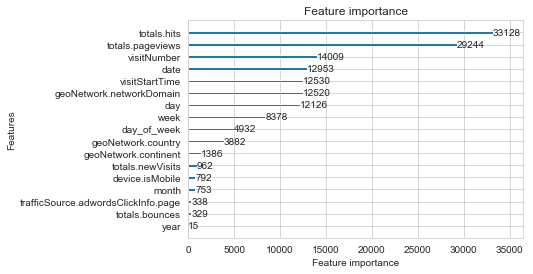

In [571]:
lgb.plot_importance(gbm,max_num_features=30)